In [3]:
import torch
import pandas as pd
import numpy as np
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import degree
import matplotlib.pyplot as plt
from collections import Counter

In [4]:
dataset = Planetoid(root='.',name='Cora')
data = dataset[0]

In [5]:
degrees = degree(data.edge_index[0]).numpy() #각 노드의 이웃갯수
numbers = Counter(degrees) #갯수만큼 딕셔너리 형태로 저장

<BarContainer object of 37 artists>

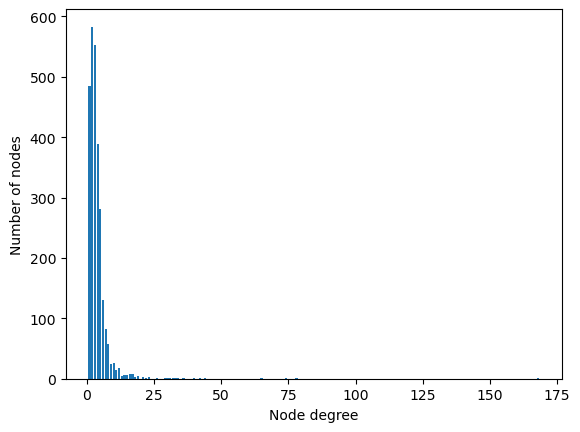

In [6]:
fig,ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(),numbers.values()) #각 차수가 몇개 있는지

위 그래프를 보면 노드의 차수가 치우쳐져있음=>(따라서, 차수의 정규화가 필요함)

In [7]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [8]:
def accuracy(pred_y,y):
    return ((pred_y==y).sum()/len(y)).item()

In [9]:
class GCN(torch.nn.Module):
    def __init__(self,dim_in,dim_h,dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in,dim_h)
        self.gcn2 = GCNConv(dim_h,dim_out)
    
    def forward(self,x,edge_index):
        h = self.gcn1(x,edge_index)
        h = F.relu(h)
        h = self.gcn2(h,edge_index)
        return h
    
    def fit(self,data,epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),lr=0.01,weight_decay=5e-4)
        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x,data.edge_index) #로짓값
            loss = criterion(out[data.train_mask],data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1),data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if epoch%20==0:
                val_loss = criterion(out[data.val_mask],data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1),data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train_Loss : {loss:.3f} | Train_Acc : {acc*100:>5.2f} | Val_Loss : {val_loss:.3f} | Val_Acc : {val_acc:>5.2f}')
    
    def test(self,data):
        torch.no_grad()
        self.eval()
        out = self(data.x,data.edge_index)
        acc = accuracy(out[data.test_mask].argmax(dim=1),data.y[data.test_mask])
        return acc
        

In [10]:
gcn = GCN(dataset.num_features,16,dataset.num_classes)
print(gcn)

GCN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 7)
)


In [11]:
gcn.fit(data,epochs=100)

Epoch   0 | Train_Loss : 1.947 | Train_Acc : 12.14 | Val_Loss : 1.952 | Val_Acc :  0.09
Epoch  20 | Train_Loss : 0.146 | Train_Acc : 99.29 | Val_Loss : 0.901 | Val_Acc :  0.77
Epoch  40 | Train_Loss : 0.019 | Train_Acc : 100.00 | Val_Loss : 0.810 | Val_Acc :  0.78
Epoch  60 | Train_Loss : 0.016 | Train_Acc : 100.00 | Val_Loss : 0.773 | Val_Acc :  0.78
Epoch  80 | Train_Loss : 0.018 | Train_Acc : 100.00 | Val_Loss : 0.755 | Val_Acc :  0.78
Epoch 100 | Train_Loss : 0.016 | Train_Acc : 100.00 | Val_Loss : 0.751 | Val_Acc :  0.77


In [12]:
Test_acc = gcn.test(data)
print(f'Test_acc : {Test_acc*100:.5f}')

Test_acc : 80.20000


Cameleon Dataset

In [60]:
from torch_geometric.datasets import WikipediaNetwork
import torch_geometric.transforms as T

dataset = WikipediaNetwork(root='.',name='chameleon',transform = T.RandomNodeSplit(num_val=200,num_test=500))
                           #validation 200 / test 500 / 그 외 train
data = dataset[0] #chameleon dataset은 단일그래프


In [61]:
print(f'Dataset = {dataset}')
print('--------------')
print(f'Number of Graphs = {len(dataset)}')
print(f'Number of nodes = {data.num_nodes}')
print(f'Number of features = {dataset.num_features}')
print(f'Number of classes = {dataset.num_classes}')

Dataset = WikipediaNetwork()
--------------
Number of Graphs = 1
Number of nodes = 2277
Number of features = 2325
Number of classes = 5


In [62]:
df = pd.read_csv('wikipedia/chameleon/musae_chameleon_target.csv')

In [63]:
df # 위에 데이터 특성 파악시 클래스는 5개가 나왔지만, 회귀를 할 것이므로, 밑의 target을 기준으로 연속된 값을 예측하는 태스크를 수행한다.

,id,target
0,0,171
1,1,8089
2,2,8568
3,3,47178
4,4,3634
...,...,...
2272,2272,31418
2273,2273,2716
2274,2274,99
2275,2275,22898


In [64]:
values = np.log10(df['target'])
values

0       2.232996
1       3.907895
2       3.932879
3       4.673740
4       3.560385
          ...   
2272    4.497179
2273    3.433930
2274    1.995635
2275    4.359798
2276    2.440909
Name: target, Length: 2277, dtype: float64

In [65]:
data.y = torch.tensor(values)
data.y

tensor([2.2330, 3.9079, 3.9329,  ..., 1.9956, 4.3598, 2.4409],
       dtype=torch.float64)

In [66]:
degrees = degree(data.edge_index[0]).numpy()
numbers = Counter(degrees)

<BarContainer object of 63 artists>

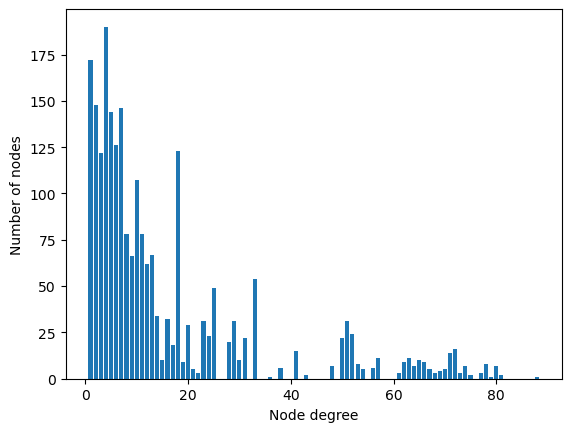

In [67]:
fig,ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(),numbers.values()) #각 차수가 몇개 있는지

/var/folders/n9/654ym8ws0_j1lt2gmvbm6k2w0000gn/T/ipykernel_63208/2048643351.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['target'],fit=norm)


<Axes: xlabel='target', ylabel='Density'>

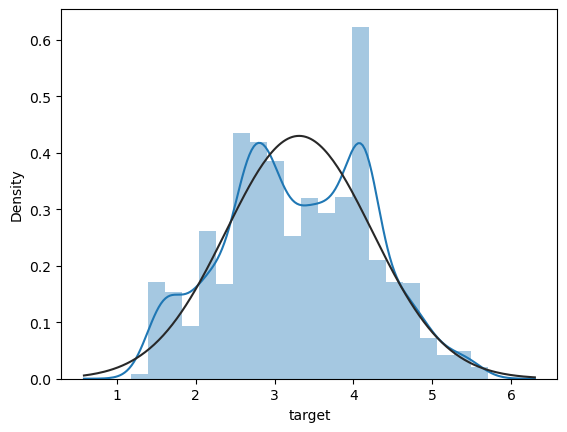

In [68]:
import seaborn as sns
from scipy.stats import norm
df['target'] = values
sns.distplot(df['target'],fit=norm)

In [69]:
class GCN(torch.nn.Module):
    def __init__(self,dim_in,dim_h,dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in,dim_h*4)
        self.gcn2 = GCNConv(dim_h*4,dim_h*2)
        self.gcn3 = GCNConv(dim_h*2,dim_h)
        self.linear = torch.nn.Linear(dim_h,dim_out)

    def forward(self,x,edge_index):
        h = self.gcn1(x,edge_index)
        h = torch.relu(h)
        h = F.dropout(h,p=0.5,training=self.training) #training은 학습 중, 평가 중일 때 dropout 적용 설정
        h = self.gcn2(h,edge_index)
        h = torch.relu(h)
        h = F.dropout(h,p=0.5,training=self.training)
        h = self.gcn3(h,edge_index)
        h = torch.relu(h)
        h = self.linear(h)
        return h

    def fit(self,data,epochs):
        optimizer = torch.optim.Adam(self.parameters(),lr=0.02,weight_decay=5e-4)
        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x,data.edge_index)
            loss = F.mse_loss(out.squeeze()[data.train_mask],data.y[data.train_mask].float())
            # (N,1) 에서 1인 차원을 압축하기 위함. MSELoss를 위해.. (두 개의 shape이 같아야함)
            # MSELoss는 또한 두 타입이 모두 float이어야 함.
            loss.backward()
            optimizer.step()

            if epoch%20==0:
                val_loss = F.mse_loss(out.squeeze()[data.val_mask],data.y[data.val_mask].float())
                print(f'Epoch : {epoch:>3} | Train_Loss : {loss:.5f} | Val_loss : {val_loss:.5f}')
        
    @torch.no_grad
    def test(self,data):
        self.eval()
        out = self(data.x,data.edge_index)
        return F.mse_loss(out.squeeze()[data.test_mask],data.y[data.test_mask].float())

In [70]:
gcn = GCN(dataset.num_features,128,1)
print(gcn)
gcn.fit(data,epochs=200)

GCN(
  (gcn1): GCNConv(2325, 512)
  (gcn2): GCNConv(512, 256)
  (gcn3): GCNConv(256, 128)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)
Epoch :   0 | Train_Loss : 12.04648 | Val_loss : 11.28606
Epoch :  20 | Train_Loss : 12.43855 | Val_loss : 11.65138
Epoch :  40 | Train_Loss : 9.74505 | Val_loss : 9.06120
Epoch :  60 | Train_Loss : 2.27108 | Val_loss : 2.36508
Epoch :  80 | Train_Loss : 0.70964 | Val_loss : 0.84575
Epoch : 100 | Train_Loss : 0.51729 | Val_loss : 0.62106
Epoch : 120 | Train_Loss : 0.44118 | Val_loss : 0.63557
Epoch : 140 | Train_Loss : 0.48464 | Val_loss : 0.58652
Epoch : 160 | Train_Loss : 0.39265 | Val_loss : 0.56724
Epoch : 180 | Train_Loss : 0.35313 | Val_loss : 0.53200
Epoch : 200 | Train_Loss : 0.37831 | Val_loss : 0.68530


In [71]:
loss = gcn.test(data)
print(f'GCN Test : {loss:.5f}')

GCN Test : 0.60231


In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

out = gcn(data.x,data.edge_index) #모델의 예측결과
y_pred = out.squeeze()[data.test_mask].detach().numpy() #평가 데이터에 대한 결과 추출.
#detach는 계산그래프에서 값만 떼오는 방식. (작업에 관여하지 않는 값)
mse = mean_squared_error(data.y[data.test_mask],y_pred)
mae = mean_absolute_error(data.y[data.test_mask],y_pred)
print('-'*50)
print(f'MSE : {mse:.4f} | MAE : {mae:.4f} | RMSE : {np.sqrt(mse):.4f}')

--------------------------------------------------
MSE : 0.6023 | MAE : 0.5966 | RMSE : 0.7761


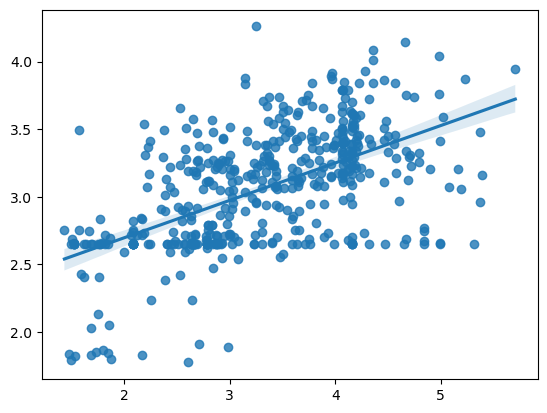

In [73]:
fig = sns.regplot(x=data.y[data.test_mask].numpy(),y=y_pred)

In [77]:
print(out.squeeze()[data.test_mask])

tensor([3.1108, 2.6485, 3.0360, 2.7952, 3.0729, 3.1169, 3.1744, 3.2985, 2.6485,
        2.7127, 2.6485, 3.7040, 3.3616, 3.0443, 3.3387, 2.6552, 1.8524, 3.5646,
        3.0595, 2.6485, 3.5322, 3.1718, 3.2175, 3.4910, 2.6485, 3.3251, 1.7916,
        3.3212, 3.0785, 3.5592, 3.2307, 2.7558, 3.3899, 3.4800, 3.7344, 3.2045,
        2.6485, 3.2069, 2.6485, 3.3329, 2.7560, 1.9120, 3.2272, 3.4965, 2.6585,
        2.6550, 3.0843, 2.6152, 3.4345, 3.4506, 2.6853, 3.0749, 3.2035, 3.1885,
        3.2508, 3.1116, 3.2705, 2.9090, 2.6485, 2.6809, 3.7926, 2.6485, 3.5103,
        2.6485, 2.6485, 2.6620, 3.1611, 2.6768, 2.6485, 2.7547, 2.6485, 2.7933,
        3.4537, 3.6738, 3.1753, 2.8611, 3.2373, 3.7908, 3.1590, 3.3746, 2.6485,
        3.2361, 3.8368, 2.6485, 2.6485, 3.5370, 3.0673, 2.8634, 3.6705, 2.7375,
        3.4283, 3.3183, 2.6618, 2.9621, 3.2651, 3.7211, 2.6485, 2.9988, 2.7123,
        3.1351, 3.6133, 2.6485, 3.2101, 3.1907, 2.6486, 2.7353, 3.1157, 2.7536,
        3.1186, 2.0307, 3.4132, 3.5035, 

In [ ]:
out.squeeze()[data.test_mask].detach() #위 결과에서 grad_fn이 빠져있는 것을 확인.

tensor([3.1108, 2.6485, 3.0360, 2.7952, 3.0729, 3.1169, 3.1744, 3.2985, 2.6485,
        2.7127, 2.6485, 3.7040, 3.3616, 3.0443, 3.3387, 2.6552, 1.8524, 3.5646,
        3.0595, 2.6485, 3.5322, 3.1718, 3.2175, 3.4910, 2.6485, 3.3251, 1.7916,
        3.3212, 3.0785, 3.5592, 3.2307, 2.7558, 3.3899, 3.4800, 3.7344, 3.2045,
        2.6485, 3.2069, 2.6485, 3.3329, 2.7560, 1.9120, 3.2272, 3.4965, 2.6585,
        2.6550, 3.0843, 2.6152, 3.4345, 3.4506, 2.6853, 3.0749, 3.2035, 3.1885,
        3.2508, 3.1116, 3.2705, 2.9090, 2.6485, 2.6809, 3.7926, 2.6485, 3.5103,
        2.6485, 2.6485, 2.6620, 3.1611, 2.6768, 2.6485, 2.7547, 2.6485, 2.7933,
        3.4537, 3.6738, 3.1753, 2.8611, 3.2373, 3.7908, 3.1590, 3.3746, 2.6485,
        3.2361, 3.8368, 2.6485, 2.6485, 3.5370, 3.0673, 2.8634, 3.6705, 2.7375,
        3.4283, 3.3183, 2.6618, 2.9621, 3.2651, 3.7211, 2.6485, 2.9988, 2.7123,
        3.1351, 3.6133, 2.6485, 3.2101, 3.1907, 2.6486, 2.7353, 3.1157, 2.7536,
        3.1186, 2.0307, 3.4132, 3.5035, 